## Importing libraries

In [2]:
import pandas as pd
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt

from shutil import copyfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization,Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
import joblib
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import glob
import random
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

## Data extraction from DeepFashion files

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!unzip -q "/content/drive/MyDrive/Advance_Machine_Learning/AML_Project/UT_Machine_Learning/AML_CNN/img.zip" -d "/content"
#!unzip -q "/content/drive/MyDrive/Advance_Machine_Learning/AML_Project/UT_Machine_Learning/AML_CNN/All_Text_files.zip" -d "/content"

Mounted at /content/drive


In [ ]:
# read the text file
with open('/content/list_category_img.txt', 'r') as file:
    lines = file.readlines()
    # Split each line into words
    list_category_img_data = [line.split() for line in lines]

with open('/content/list_category_cloth.txt', 'r') as file:
    lines = file.readlines()
    # Split each line into words
    list_category_cloth_data = [line.split() for line in lines]

with open('/content/list_eval_partition.txt', 'r') as file:
    lines = file.readlines()
    # Split each line into words
    list_eval_partition_data = [line.split() for line in lines]

# Create dataframe from data, considering 2nd row from txt file as column names
df_1 = pd.DataFrame(list_category_img_data[2:], columns=list_category_img_data[1])

df_2 = pd.DataFrame(list_category_cloth_data[2:], columns=list_category_cloth_data[1])
df_2['category_label']=df_2.index + 1
df_2['category_label']=df_2['category_label'].astype(str)

df_3 = pd.DataFrame(list_eval_partition_data[2:], columns=list_eval_partition_data[1])
df_1_3=pd.merge(df_1,df_3,how='inner')

In [ ]:
df=pd.merge(df_1_3,df_2,how='left')
df.head()

,image_name,category_label,evaluation_status,category_name,category_type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,train,Blouse,1
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,train,Blouse,1
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,val,Blouse,1
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,train,Blouse,1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,test,Blouse,1


In [ ]:
len(df)

289222

In [ ]:
df.groupby(['category_type','category_label','category_name','evaluation_status'])['image_name'].count().unstack()

evaluation_status                           test  train    val
category_type category_label category_name                    
1             1              Anorak           23    121     16
              10             Hoodie          597   2910    541
              11             Jacket         1446   7548   1473
              12             Jersey          106    534    108
              13             Parka            87    491     98
              14             Peacoat          17     63     17
              15             Poncho          106    579    106
              16             Sweater        1784   9517   1822
              17             Tank           2128  11204   2097
              18             Tee            5091  26653   5143
              19             Top            1411   7270   1397
              2              Blazer         1047   5408   1040
              20             Turtleneck       29     99     18
              3              Blouse         3416  17752   3389
              4              Bomber           39    229     41
              5              Button-Down      46    243     41
              6              Cardigan       1877   9606   1828
              7              Flannel          51    224     49
              8              Halter            2     11      4
              9              Henley          106    521     89
2             21             Capris            9     57     11
              22             Chinos           73    374     80
              23             Culottes         71    359     56
              24             Cutoffs         243   1177    249
              25             Gauchos           8     35      6
              26             Jeans           985   5126    965
              27             Jeggings         64    443     87
              28             Jodhpurs          8     32      5
              29             Joggers         575   3260    581
              30             Leggings        724   3571    718
              31             Sarong            6     18      8
              32             Shorts         2771  14195   2700
              33             Skirt          1933  10794   2046
              34             Sweatpants      408   2224    416
              35             Sweatshorts     160    781    165
              36             Trunks           41    287     58
3             37             Caftan            9     38      7
              39             Coat            304   1539    277
              40             Coverup           1     13      3
              41             Dress          9968  52138  10052
              42             Jumpsuit        849   4464    840
              43             Kaftan           17     98     11
              44             Kimono          338   1637    319
              46             Onesie           11     47     12
              47             Robe             21    107     22
              48             Romper          994   5425    989

### From the images, we are only extracting images for category labels as 'dress', 'tee', 'blouse', 'shorts', 'skirt' for building our model and pedicting a new image belonging to one of these label

In [ ]:
#new_df=df[(df['category_type']=='3') & (df['category_label'].isin(['39','41','42','44','48']))]
new_df=df[(df['category_label'].isin(['3','18','41','6','26']))]

### Creating train folder for images

In [ ]:
# Specify the base directory in the local environment of the virtual machine
base_dir = "/content/AML_CNN"

# Create the base directory if it does not exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    print(f"Directory {base_dir} created.")
else:
    print(f"Directory {base_dir} already exists.")

# Change directory to the newly created directory
os.chdir(base_dir)
print("Current Working Directory:", os.getcwd())

Directory /content/AML_CNN created.
Current Working Directory: /content/AML_CNN


In [ ]:
os.chdir("/content/AML_CNN")
if os.path.isdir('trian/dress') is False:
    os.makedirs('train/dress')
    os.makedirs('train/tee')
    os.makedirs('train/blouse')
    os.makedirs('train/Cardigan')
    os.makedirs('train/Jeans')

In [ ]:
parent_path="/content"
#label=['coat','dress','jumpsuit','kimino','romper']
#cat_list= ['39','41','42','44','48']

label=['dress','tee','blouse','Cardigan','Jeans']
cat_list= ['41','18','3','6','26']

#### Moving 5000 images from these category labels to train folder

In [ ]:
for z,cat in enumerate(cat_list):
    train_sample = new_df[(new_df['category_label']== cat) & (new_df['evaluation_status']== 'train')].sample(n=5000)['image_name']
    train_sample=train_sample.to_list()
    if cat=='41':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'train/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='18':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'train/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='3':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'train/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='6':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'train/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='26':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'train/'+label[z]+'/'+str(i)+'.jpg')

#### Creating Validation folder for images

In [ ]:
os.chdir("/content/AML_CNN")
if os.path.isdir('valid/dress') is False:
    os.makedirs('valid/dress')
    os.makedirs('valid/tee')
    os.makedirs('valid/blouse')
    os.makedirs('valid/Cardigan')
    os.makedirs('valid/Jeans')

#### Moving 500 images from these category labels to validation folder

In [ ]:
for z,cat in enumerate(cat_list):
    val_sample = new_df[(new_df['category_label']== cat) & (new_df['evaluation_status']== 'val')].sample(n=500)['image_name']
    val_sample=val_sample.to_list()
    if cat=='41':
        for i,y in enumerate(val_sample):
            shutil.copy(parent_path + "/" + y, 'valid/' + label[z] + '/' + str(i) + '.jpg')
    elif cat=='18':
        for i,y in enumerate(val_sample):
            shutil.copy(parent_path+"/"+y,'valid/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='3':
        for i,y in enumerate(val_sample):
            shutil.copy(parent_path+"/"+y,'valid/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='6':
        for i,y in enumerate(val_sample):
            shutil.copy(parent_path+"/"+y,'valid/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='26':
        for i,y in enumerate(val_sample):
            shutil.copy(parent_path+"/"+y,'valid/'+label[z]+'/'+str(i)+'.jpg')

#### Creating test folder for images

In [ ]:
os.chdir(parent_path)
if os.path.isdir('test/dress') is False:
    os.makedirs('test/dress')
    os.makedirs('test/tee')
    os.makedirs('test/blouse')
    os.makedirs('test/Cardigan')
    os.makedirs('test/Jeans')

#### Moving 50 images from these category labels to test folder

In [ ]:
for z,cat in enumerate(cat_list):
    train_sample = new_df[(new_df['category_label']== cat) & (new_df['evaluation_status']== 'test')].sample(n=50)['image_name']
    train_sample=train_sample.to_list()
    if cat=='41':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'test/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='18':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'test/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='3':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'test/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='6':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'test/'+label[z]+'/'+str(i)+'.jpg')
    elif cat=='26':
        for i,y in enumerate(train_sample):
            shutil.copy(parent_path+"/"+y,'test/'+label[z]+'/'+str(i)+'.jpg')

### Image processing for the model using VGG preprocess imputs, size, classes

In [ ]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
        .flow_from_directory(directory='/content/AML_CNN/train',target_size=(224,224),classes=['dress','tee','blouse','Cardigan','Jeans'],batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
        .flow_from_directory(directory='/content/AML_CNN/valid',target_size=(224,224),classes=['dress','tee','blouse','Cardigan','Jeans'],batch_size=10)

Found 25000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


#### Displaying train images

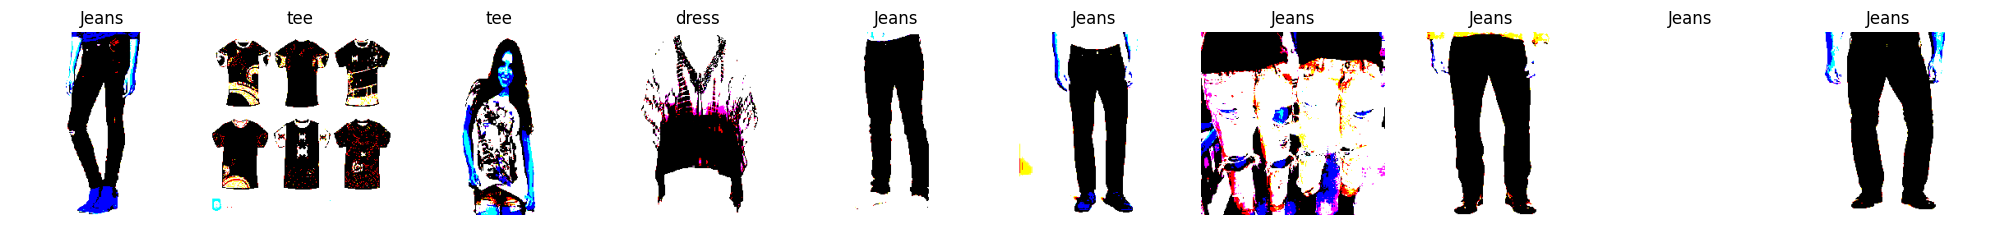

[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
def plotImages(images_arr, labels_arr, label_names):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    for idx, (img, ax, label) in enumerate(zip(images_arr, axes, labels_arr)):
        ax.imshow(img)
        ax.axis('off')
        label_idx = np.argmax(label)
        ax.set_title(label_names[label_idx])
    plt.tight_layout()
    plt.show()

# Assuming you have defined label_names elsewhere in your code
label_names = ['dress', 'tee', 'blouse', 'Cardigan', 'Jeans']

imgs, labels = next(train_batches)
plotImages(imgs, labels, label_names)

print(labels)

#### Displaying valid images

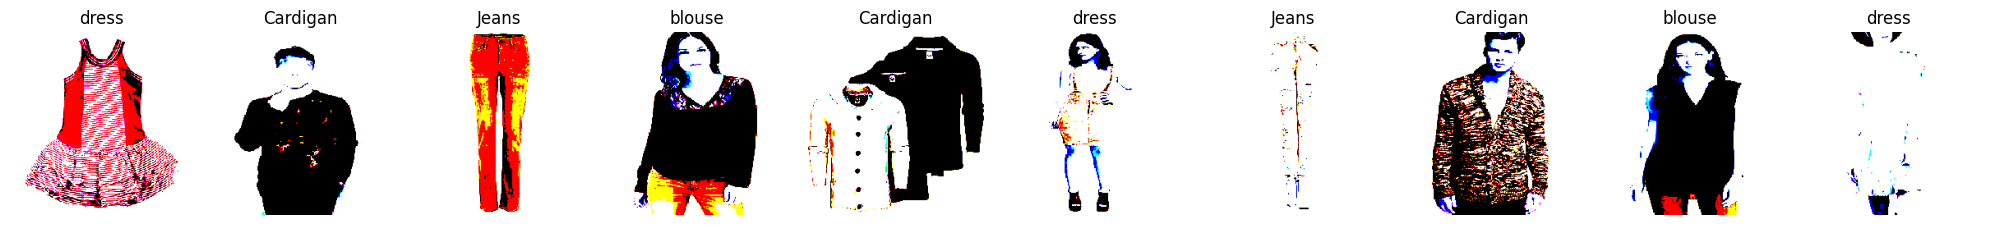

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
imgs,labels=next(valid_batches)
plotImages(imgs, labels, label_names)
print(labels)

## Building our first CNN model with few layers

In [ ]:
model_simple=Sequential([Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  Flatten(),
                  Dense(units=5,activation='softmax'),
])

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [ ]:
model_simple.compile(optimizer= Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
Model_1= model_simple.fit(x=train_batches, validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
2500/2500 [==============================] - 65s 24ms/step - loss: 3.9868 - accuracy: 0.4624 - val_loss: 1.2042 - val_accuracy: 0.5284
Epoch 2/10
2500/2500 [==============================] - 59s 24ms/step - loss: 0.8253 - accuracy: 0.6880 - val_loss: 1.3104 - val_accuracy: 0.5000
Epoch 3/10
2500/2500 [==============================] - 59s 24ms/step - loss: 0.3622 - accuracy: 0.8762 - val_loss: 1.6655 - val_accuracy: 0.5116
Epoch 4/10
2500/2500 [==============================] - 58s 23ms/step - loss: 0.1676 - accuracy: 0.9505 - val_loss: 2.0086 - val_accuracy: 0.5008
Epoch 5/10
2500/2500 [==============================] - 58s 23ms/step - loss: 0.1164 - accuracy: 0.9666 - val_loss: 2.3899 - val_accuracy: 0.5248
Epoch 6/10
2500/2500 [==============================] - 57s 23ms/step - loss: 0.0875 - accuracy: 0.9781 - val_loss: 2.7670 - val_accuracy: 0.5040
Epoch 7/10
2500/2500 [==============================] - 56s 22ms/step - loss: 0.0761 - accuracy: 0.9796 - val_loss: 3.1750 -

### Interpretation:
##### training set of 1000 images , our simple model training accuracy is 99%, validation accuracy is 38% with 10 epochs

##### training set of 5000 images , our simple model training accuracy is 99%, validation accuracy is 50% with 10 epochs

We see the validation accuracy has improved with training on more images, our simple model is overfitting with high training accuracy and low validation accuracy.


In [ ]:
## Saving the model for future predictions

model_simple.save("/content/model_simple.h5")
model_simple.save("/content/model_simple.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_simple.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/model_simple.h5")
model_simple.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/model_simple.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
import os
import tempfile
import shutil
import zipfile
from tensorflow.keras.models import Sequential

# Assuming model_simple is your already trained model

# Path for your zip file
zip_path = "/content/drive/MyDrive/Advance_Machine_Learning/Models/Model_simple.zip"

# Using temporary files to save the model
with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
    model_simple.save(tmp_file.name, save_format='h5')
    # Create a zip file and write the H5 file to it
    with zipfile.ZipFile(zip_path, 'w') as myzip:
        myzip.write(tmp_file.name, arcname="model.h5")
    os.unlink(tmp_file.name)  # Clean up the temporary H5 file

# Handle TensorFlow SavedModel format
temp_dir = tempfile.mkdtemp()
model_simple.save(temp_dir)  # Saves in SavedModel format by default

# Append the SavedModel directory to the existing zip file
with zipfile.ZipFile(zip_path, 'a') as myzip:  # 'a' to append
    for foldername, subfolders, filenames in os.walk(temp_dir):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, start=temp_dir)  # Relative path in zip
            myzip.write(file_path, arcname=arcname)

# Clean up the temporary directory
shutil.rmtree(temp_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plotting Accuracy & Loss for the model

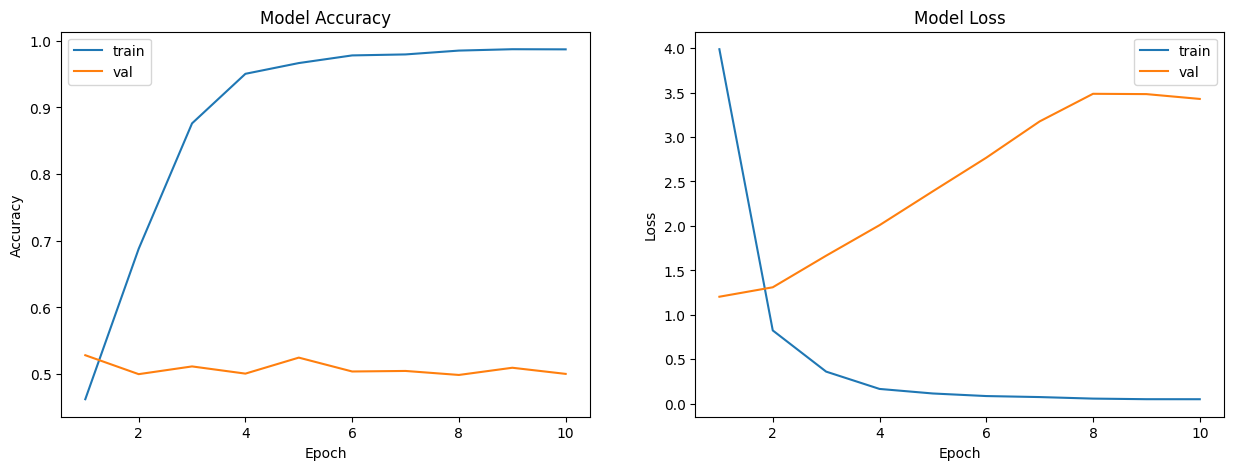

In [ ]:
#1. Function to plot model's validation loss and validation accuracy


def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(Model_1)

### This model is overfitting, to reduce overfitting we use drop out and adding more layers to our model

The main idea behind using dropout is simple, to avoid overfitting. The most popular regularization method is used in Neural networks.

During training time, at each iteration, a neuron is temporarily “dropped” or disabled with probability p. This means all the inputs and outputs to this neuron will be disabled at the current iteration. The dropped-out neurons are resampled with probability p at every training step, so a dropped-out neuron at one step can be active at the next one. The hyperparameter p is called the dropout rate and it’s typically a number around 0.5, corresponding to 50% of the neurons being dropped

In [ ]:
from tensorflow.keras.layers import Dropout

model_dropout=Sequential([Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
                    Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
                  MaxPool2D(pool_size=(2,2),strides=2),
                  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
                    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
                  MaxPool2D(pool_size=(2,2),strides=2),
                    Conv2D(filters=128,kernel_size=3,padding="same", activation="relu"),
                    Conv2D(filters=128,kernel_size=3,padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=2),
                  Flatten(),
                    Dropout(0.5,noise_shape=None,seed=None),
                  Dense(units=5,activation='softmax'),
])


In [ ]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                 

In [ ]:
model_dropout.compile(optimizer= Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
Model_2= model_dropout.fit(x=train_batches, validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
2500/2500 [==============================] - 104s 39ms/step - loss: 1.3255 - accuracy: 0.5051 - val_loss: 1.0240 - val_accuracy: 0.5848
Epoch 2/10
2500/2500 [==============================] - 98s 39ms/step - loss: 0.9642 - accuracy: 0.6155 - val_loss: 1.0013 - val_accuracy: 0.5912
Epoch 3/10
2500/2500 [==============================] - 97s 39ms/step - loss: 0.8656 - accuracy: 0.6572 - val_loss: 0.9344 - val_accuracy: 0.6260
Epoch 4/10
2500/2500 [==============================] - 97s 39ms/step - loss: 0.7707 - accuracy: 0.7029 - val_loss: 0.9269 - val_accuracy: 0.6276
Epoch 5/10
2500/2500 [==============================] - 97s 39ms/step - loss: 0.6782 - accuracy: 0.7388 - val_loss: 0.9417 - val_accuracy: 0.6332
Epoch 6/10
2500/2500 [==============================] - 98s 39ms/step - loss: 0.5760 - accuracy: 0.7800 - val_loss: 1.0082 - val_accuracy: 0.6304
Epoch 7/10
2500/2500 [==============================] - 98s 39ms/step - loss: 0.4863 - accuracy: 0.8153 - val_loss: 1.0165 

### Interpretation:
##### training set of 1000 images , our dropout model train accuracy of 92%, validation accuracy of 46 % with 10 epochs

##### training set of 5000 images , our drop out model training accuracy is 88%, validation accuracy is 62% with 10 epochs

While our validation accuracy has improved, we are still training our model on only 5k images and 10 epoches, training on higher number of images & epoch is significantly slow and needs more GPU. Hence we try to fine tune the existing models and use their weights to train our model as next step

In [ ]:
## Saving the model for future predictions
model_dropout.save("/content/model_dropout.h5")
model_dropout.save("/content/model_dropout.keras")


In [ ]:
model_dropout.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/model_dropout.h5")
model_dropout.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/model_dropout.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
import os
import tempfile
import shutil
import zipfile
from tensorflow.keras.models import Sequential

# Assuming model_dropout is your already trained model

# Path for your zip file
zip_path = "/content/drive/MyDrive/Advance_Machine_Learning/Models/Model_dropout.zip"

# Using temporary files to save the model
with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
    model_dropout.save(tmp_file.name, save_format='h5')
    # Create a zip file and write the H5 file to it
    with zipfile.ZipFile(zip_path, 'w') as myzip:
        myzip.write(tmp_file.name, arcname="model.h5")
    os.unlink(tmp_file.name)  # Clean up the temporary H5 file

# Handle TensorFlow SavedModel format
temp_dir = tempfile.mkdtemp()
model_dropout.save(temp_dir)  # Saves in SavedModel format by default

# Append the SavedModel directory to the existing zip file
with zipfile.ZipFile(zip_path, 'a') as myzip:  # 'a' to append
    for foldername, subfolders, filenames in os.walk(temp_dir):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, start=temp_dir)  # Relative path in zip
            myzip.write(file_path, arcname=arcname)

# Clean up the temporary directory
shutil.rmtree(temp_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


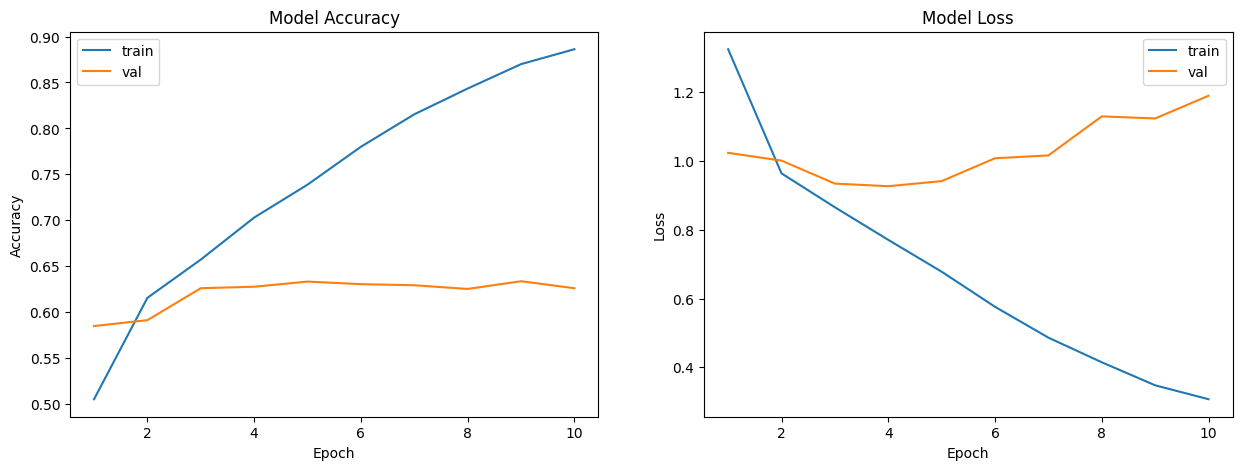

In [ ]:
plot_model_history(Model_2)

### Adding more complex deep layers to our model to access accuracy

In [ ]:
# # Creating a more complex model with more deep layers

model_complex=Sequential([Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(5, activation='softmax')
])

model_complex.compile(optimizer= Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
Model_3= model_complex.fit(x=train_batches, validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
2500/2500 [==============================] - 407s 158ms/step - loss: 1.4959 - accuracy: 0.3048 - val_loss: 1.3029 - val_accuracy: 0.4556
Epoch 2/10
2500/2500 [==============================] - 396s 158ms/step - loss: 1.2968 - accuracy: 0.4253 - val_loss: 1.1289 - val_accuracy: 0.5276
Epoch 3/10
2500/2500 [==============================] - 396s 158ms/step - loss: 1.1281 - accuracy: 0.5242 - val_loss: 0.9819 - val_accuracy: 0.6080
Epoch 4/10
2500/2500 [==============================] - 397s 159ms/step - loss: 1.0204 - accuracy: 0.5787 - val_loss: 0.8771 - val_accuracy: 0.6528
Epoch 5/10
2500/2500 [==============================] - 395s 158ms/step - loss: 0.9352 - accuracy: 0.6200 - val_loss: 0.8531 - val_accuracy: 0.6648
Epoch 6/10
2500/2500 [==============================] - 396s 159ms/step - loss: 0.8667 - accuracy: 0.6557 - val_loss: 0.8489 - val_accuracy: 0.6704
Epoch 7/10
2500/2500 [==============================] - 396s 158ms/step - loss: 0.7994 - accuracy: 0.6817 - val_

In [ ]:
#save the model for future prediction
model_complex.save("/content/model_complex.h5")
model_complex.save("/content/model_complex.keras")

In [ ]:
model_complex.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/model_complex.h5")
model_complex.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/model_complex.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
import os
import tempfile
import shutil
import zipfile
from tensorflow.keras.models import Sequential

# Assuming model_complex is your already trained model

# Path for your zip file
zip_path = "/content/drive/MyDrive/Advance_Machine_Learning/Models/Model_complex.zip"

# Using temporary files to save the model
with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
    model_complex.save(tmp_file.name, save_format='h5')
    # Create a zip file and write the H5 file to it
    with zipfile.ZipFile(zip_path, 'w') as myzip:
        myzip.write(tmp_file.name, arcname="model.h5")
    os.unlink(tmp_file.name)  # Clean up the temporary H5 file

# Handle TensorFlow SavedModel format
temp_dir = tempfile.mkdtemp()
model_complex.save(temp_dir)  # Saves in SavedModel format by default

# Append the SavedModel directory to the existing zip file
with zipfile.ZipFile(zip_path, 'a') as myzip:  # 'a' to append
    for foldername, subfolders, filenames in os.walk(temp_dir):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, start=temp_dir)  # Relative path in zip
            myzip.write(file_path, arcname=arcname)

# Clean up the temporary directory
shutil.rmtree(temp_dir)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


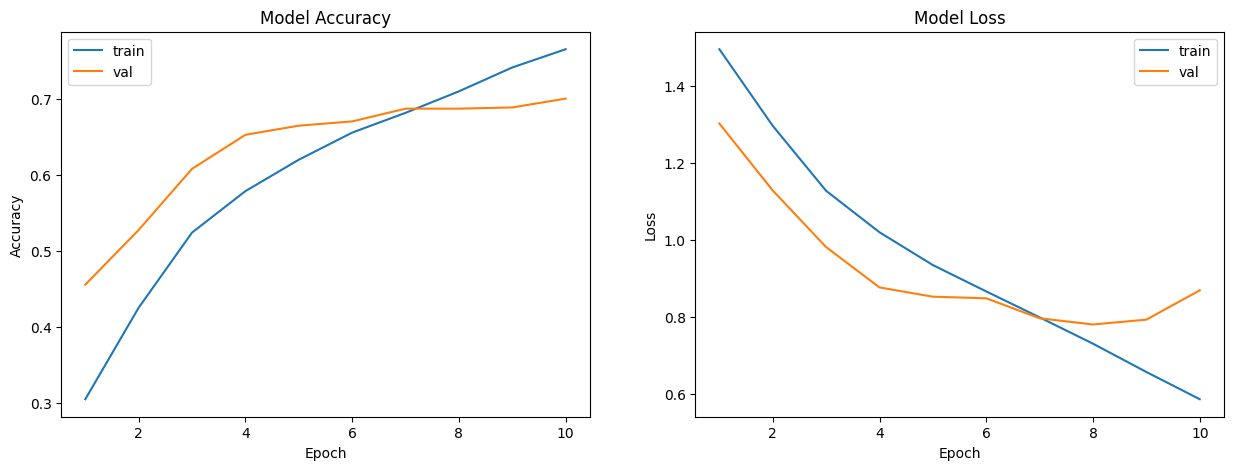

In [ ]:
plot_model_history(Model_3)

### Interpretation:

##### training set of 5000 images , our complex model training accuracy is 76%, validation accuracy is 70% with 10 epochs

While our validation accuracy has improved to 70%, we are still training our model on only 5k images and 10 epoches. The validation accuracy could be further improved by increasing the training data set to higher number of images. Unfortunately for the 5 lables, we have a restriction on the number of images.

### Benchmarking with other model accuracy

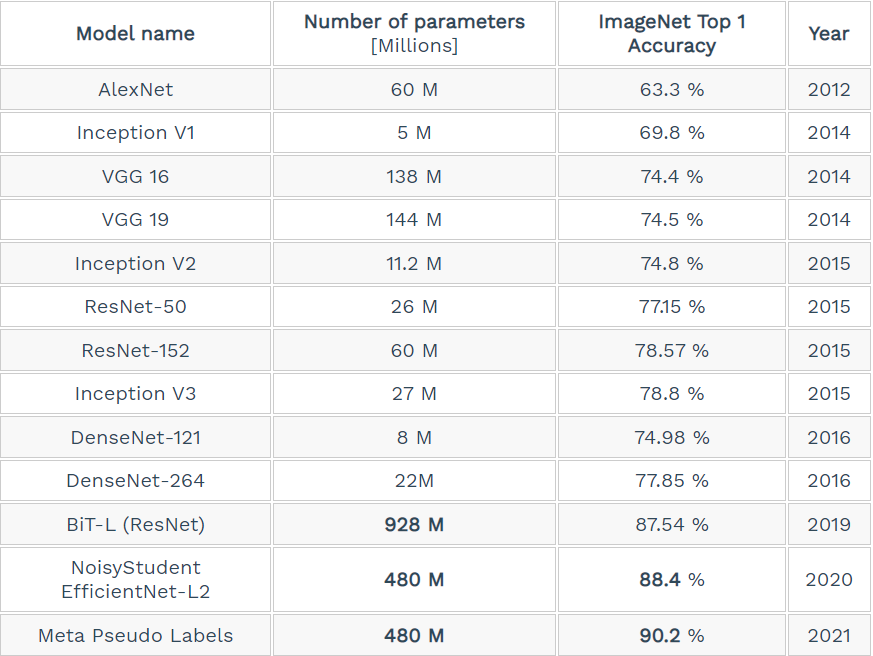

#### With our complex CNN model, we are in range with the industry benchmarks

### Fine tuning the VGG19 model and using the existing weights for classification

In [ ]:
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# Add a final softmax layer with 5 nodes for classification output
x = Dense(5, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Here, we’ll be using the Adam optimizer to reach the global minima while training the model. The Adam optimizer will help us to get out of local minima and reach global minima if we get stuck while training. We’ll also specify the learning rate of the optimizer, in this case, it’s set at 0.001. If our training bounces a lot on epochs, then we need to decrease the learning rate so that we can reach global minima.

In [ ]:

early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model


# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
# fit the model
vgg19_model = model.fit(x=train_batches, validation_data=valid_batches,epochs=6,verbose=2,shuffle=True)

Epoch 1/6
2500/2500 - 188s - loss: 3.2936 - accuracy: 0.6024 - val_loss: 0.8688 - val_accuracy: 0.6860 - 188s/epoch - 75ms/step
Epoch 2/6
2500/2500 - 187s - loss: 1.1646 - accuracy: 0.6218 - val_loss: 0.9405 - val_accuracy: 0.6848 - 187s/epoch - 75ms/step
Epoch 3/6
2500/2500 - 186s - loss: 1.1737 - accuracy: 0.6249 - val_loss: 0.8647 - val_accuracy: 0.6748 - 186s/epoch - 74ms/step
Epoch 4/6
2500/2500 - 185s - loss: 1.1010 - accuracy: 0.6290 - val_loss: 0.8969 - val_accuracy: 0.6792 - 185s/epoch - 74ms/step
Epoch 5/6
2500/2500 - 186s - loss: 1.0583 - accuracy: 0.6414 - val_loss: 0.9246 - val_accuracy: 0.6684 - 186s/epoch - 74ms/step
Epoch 6/6
2500/2500 - 186s - loss: 0.9810 - accuracy: 0.6468 - val_loss: 0.9181 - val_accuracy: 0.6756 - 186s/epoch - 74ms/step


In [ ]:
#Saving the model for future predictions
model.save('/content/vgg19_model.h5')
model.save('/content/vgg19_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/vgg19_model.h5")
model.save("'/content/drive/MyDrive/Advance_Machine_Learning/Models/vgg19_model.keras")

In [64]:
import os
import tempfile
import shutil
import zipfile
from tensorflow.keras.models import Sequential

# Assuming model_complex is your already trained model

# Path for your zip file
zip_path = "/content/drive/MyDrive/Advance_Machine_Learning/Models/Model_vgg19.zip"

# Using temporary files to save the model
with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
    model.save(tmp_file.name, save_format='h5')
    # Create a zip file and write the H5 file to it
    with zipfile.ZipFile(zip_path, 'w') as myzip:
        myzip.write(tmp_file.name, arcname="model.h5")
    os.unlink(tmp_file.name)  # Clean up the temporary H5 file

# Handle TensorFlow SavedModel format
temp_dir = tempfile.mkdtemp()
model.save(temp_dir)  # Saves in SavedModel format by default

# Append the SavedModel directory to the existing zip file
with zipfile.ZipFile(zip_path, 'a') as myzip:  # 'a' to append
    for foldername, subfolders, filenames in os.walk(temp_dir):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, start=temp_dir)  # Relative path in zip
            myzip.write(file_path, arcname=arcname)

# Clean up the temporary directory
shutil.rmtree(temp_dir)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


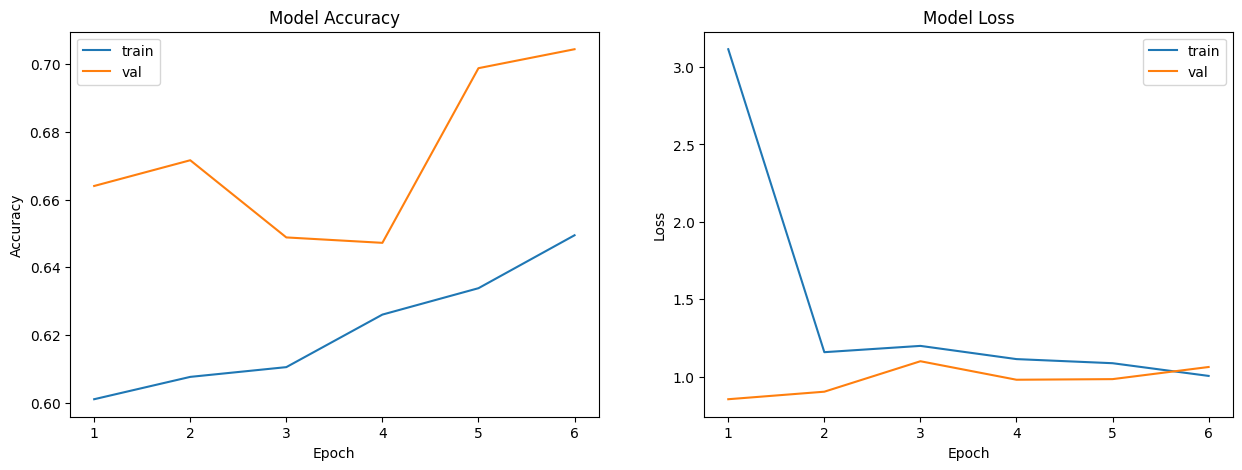

In [ ]:
plot_model_history(vgg19_model)

### Interpretation:

##### training set of 5000 images , vgg19 model training accuracy is 64%, validation accuracy is 67% with 6 epochs

We use finetuning only when we don;t have enough data images of our own. Fine tuned model may not give better results as they are using weights from a pre-trainined vgg model which is trainined on all images which are not specific to Fashion/clothes. Hence we use our complex model for our website

# Testing the model on Test images

In [3]:
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
        .flow_from_directory(directory='C:/Users/I068117/UT_Machine Learning/AML CNN/test',target_size=(224,224),classes=['dress','tee','blouse','Cardigan','Jeans'], batch_size=250)

Found 250 images belonging to 5 classes.


In [5]:
# Load the model from the specified path
from tensorflow.keras.models import load_model
simple_model = load_model('C:/Users/I068117/UT_Machine Learning/AML CNN/model_simple.h5')
dropout_model = load_model('C:/Users/I068117/UT_Machine Learning/AML CNN/model_dropout.h5')
complex_model = load_model('C:/Users/I068117/UT_Machine Learning/AML CNN/model_complex.h5')
vgg_model = load_model('C:/Users/I068117/UT_Machine Learning/AML CNN/model_vgg19.h5')

In [8]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import warnings
warnings.filterwarnings("ignore")


loss, accuracy = simple_model.evaluate_generator(test_batches)
print('Accuracy for simple model')
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
print('-----------------------')
loss, accuracy = dropout_model.evaluate_generator(test_batches)
print('Accuracy for dropout_model')
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
print('-----------------------')
loss, accuracy = complex_model.evaluate_generator(test_batches)
print('Accuracy for complex_modell')
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
print('-----------------------')
loss, accuracy = vgg_model.evaluate_generator(test_batches)
print('Accuracy for vgg_model19')
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
print('-----------------------')

Accuracy for simple model
Test: accuracy = 0.492000  ;  loss = 3.343116 
-----------------------
Accuracy for dropout_model
Test: accuracy = 0.656000  ;  loss = 1.069690 
-----------------------
Accuracy for complex_modell
Test: accuracy = 0.732000  ;  loss = 0.852776 
-----------------------
Accuracy for vgg_model19
Test: accuracy = 0.708000  ;  loss = 0.809823 
-----------------------


In [13]:
y_pred =  simple_model.predict_generator(test_batches)
y_pred = np.where(y_pred > 0.5, 1,0)
y_g=[]
for i in range(1):
    _, label = next(test_batches)
    y_g.append(label)
y_true = np.concatenate(y_g)
confusion_mtx = multilabel_confusion_matrix(y_true, y_pred)
print('Confusion Matrix for Simple Model for 5 labels dress,tee,blouse,Cardigan,Jeans')
print(confusion_mtx)
print(classification_report(y_true, y_pred))
print('-----------------------')
      
y_pred =  dropout_model.predict_generator(test_batches)
y_pred = np.where(y_pred > 0.5, 1,0)
y_g=[]
for i in range(1):
    _, label = next(test_batches)
    y_g.append(label)
y_true = np.concatenate(y_g)
confusion_mtx = multilabel_confusion_matrix(y_true, y_pred)
print('Confusion Matrix for Dropout Model for 5 labels dress,tee,blouse,Cardigan,Jeans')
print(confusion_mtx)
print(classification_report(y_true, y_pred))
print('-----------------------')
      
y_pred =  complex_model.predict_generator(test_batches)
y_pred = np.where(y_pred > 0.5, 1,0)
y_g=[]
for i in range(1):
    _, label = next(test_batches)
    y_g.append(label)
y_true = np.concatenate(y_g)
confusion_mtx = multilabel_confusion_matrix(y_true, y_pred)
print('Confusion Matrix for Complex Model for 5 labels dress,tee,blouse,Cardigan,Jeans')
print(confusion_mtx)
print(classification_report(y_true, y_pred))
print('-----------------------')
      
y_pred =  vgg_model.predict_generator(test_batches)
y_pred = np.where(y_pred > 0.5, 1,0)
y_g=[]
for i in range(1):
    _, label = next(test_batches)
    y_g.append(label)
y_true = np.concatenate(y_g)
confusion_mtx = multilabel_confusion_matrix(y_true, y_pred)
print('Confusion Matrix for Vgg19 Model for 5 labels dress,tee,blouse,Cardigan,Jeans')
print(confusion_mtx)
print(classification_report(y_true, y_pred))
print('-----------------------')

Confusion Matrix for Simple Model for 5 labels dress,tee,blouse,Cardigan,Jeans
[[[164  36]
  [ 40  10]]

 [[157  43]
  [ 36  14]]

 [[173  27]
  [ 37  13]]

 [[163  37]
  [ 40  10]]

 [[156  44]
  [ 42   8]]]
              precision    recall  f1-score   support

           0       0.22      0.20      0.21        50
           1       0.25      0.28      0.26        50
           2       0.33      0.26      0.29        50
           3       0.21      0.20      0.21        50
           4       0.15      0.16      0.16        50

   micro avg       0.23      0.22      0.22       250
   macro avg       0.23      0.22      0.22       250
weighted avg       0.23      0.22      0.22       250
 samples avg       0.22      0.22      0.22       250

-----------------------
Confusion Matrix for Dropout Model for 5 labels dress,tee,blouse,Cardigan,Jeans
[[[159  41]
  [ 39  11]]

 [[165  35]
  [ 44   6]]

 [[168  32]
  [ 43   7]]

 [[160  40]
  [ 44   6]]

 [[162  38]
  [ 42   8]]]
              

### Generating Image Captions for the images

In [18]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration# specify model to be used
hf_model = "Salesforce/blip-image-captioning-large"
# use GPU if it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# preprocessor will prepare images for the model
processor = BlipProcessor.from_pretrained(hf_model)
# then we initialize the model itself
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

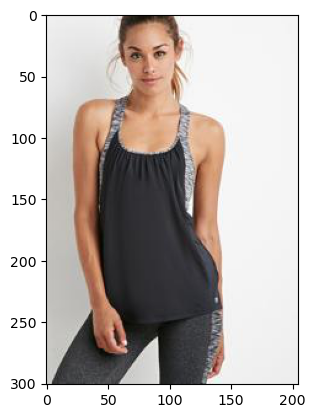

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#update the file path to an image. In Flask, this should be the path of the uploaded image.
image = mpimg.imread('C:/Users/I068117/UT_Machine Learning/AML CNN/img/2-in-1_Space_Dye_Athletic_Tank/img_00000001.jpg')
imgplot = plt.imshow(image)
plt.show()

In [20]:
inputs = processor(image, return_tensors="pt").to(device)
# generate the caption
out = model.generate(**inputs, max_new_tokens=20)
# get the caption
caption = processor.decode(out[0], skip_special_tokens=True)

#printing the caption of the use image
caption

'a woman in a black tank top and leggings posing for a picture'

### We can use the caption and use google API/charGPT API to generate more creative producte description using the image caption.

In [14]:
#importing libraries
#!pip install ipywidgets

import ipywidgets
import json
from ipywidgets import widgets
import os
import requests

import pandas as pd
import numpy as np

In [15]:
# Starter function for accessing chatGPT API... Replace this with the secret key (sk.txt) provided
with open('C:/Users/I068117/UT_Machine Learning/Text-Analytics_NLP/Sentiment Analysis/irpa-r701-genaixl-customer-fd-sk.txt') as f:
    sk = json.load(f)
    
# Replace this with the resource group provided
resource_group = widgets.Text(
    value='e98ee3d7-45fa-43cb-8773-fb106ed18d67', # resource group
    placeholder='Resource group of deployments',
    description='',
    disabled=False
)
resource_group

os.environ['AICORE_LLM_AUTH_URL'] = sk['url']+"/oauth/token"
os.environ['AICORE_LLM_CLIENT_ID'] = sk['clientid']
os.environ['AICORE_LLM_CLIENT_SECRET'] = sk['clientsecret']
os.environ['AICORE_LLM_API_BASE'] = sk["serviceurls"]["AI_API_URL"]+ "/v2"
os.environ['AICORE_LLM_RESOURCE_GROUP'] = resource_group.value
os.environ['LLM_COMMONS_PROXY'] = 'aicore'

response = requests.post(
        f'{os.environ["AICORE_LLM_AUTH_URL"]}/oauth/token',
        data={"grant_type": "client_credentials"},
        auth=(os.environ['AICORE_LLM_CLIENT_ID'], os.environ['AICORE_LLM_CLIENT_SECRET']),
        timeout=8000,
)
auth_token = response.json()["access_token"]

In [16]:
# Function to get the api response with the context & question
#import langchain
from typing import Any, List, Mapping, Optional
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM

class OpenAILLM(LLM):

        
    @property
    def _llm_type(self) -> str:
        return "SAP OpenAI API"
    
    def _call(self,prompt: str,stop: Optional[List[str]] = None,run_manager: Optional[CallbackManagerForLLMRun] = None,**kwargs: Any,) -> str:
        
        #if stop is not None:
            #raise ValueError("stop kwargs are not permitted.")

        test_input = {
            "model" : "gpt-35-turbo-16k ",
            "messages" : [{ "content": prompt,"role": "user"}],
            "max_tokens": 1000
        }
        
        deployment_url= "https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com/v2/inference/deployments/dc4baab3a2f39a75"
        endpoint = f"{deployment_url}/chat/completions?api-version=2023-05-15" # endpoint implemented in serving engine
        #print(endpoint)
        headers = {"Authorization": f"Bearer {auth_token}",
                   'ai-resource-group': resource_group.value,
                   "Content-Type": "application/json"}
        response = requests.post(endpoint, headers=headers, json=test_input)
        #converting the response to Json dictionary format in python to read the content
        data = response.json()
        return data['choices'][0]['message']['content']
    

In [21]:
llm = OpenAILLM()
prompt = f'Create a creative product description in 3 sentences using the {caption}'
llm.invoke(prompt)

'Introducing our chic "Infinite Confidence" Photoshoot Set, where fashion meets empowerment! Picture this: a woman in a sleek black tank top and leggings, striking a pose that exudes the epitome of self-assurance. Effortlessly elegant, this ensemble is designed to transform any photo into a visual representation of limitless confidence, perfect for those seeking a boost in their self-esteem journey. Get ready to capture the essence of your inner power with this unbeatable outfit!'